In [1]:
# load the necessary packages 
using CSV, DataFrames, Glob
using Statistics, Plots
# optimization packages
using JuMP, GLPK

In this Jupyter notebook, we demonstrate how to solve the index fund problem, which is an integer program, using data from a dataset taken from real life.

# 1. Examining the data

We have prepared a set of time series data of the stock prices in the US's S&P 500 market under the folder "individual_stocks_5yr". These data are taken from Kaggle ( https://www.kaggle.com/camnugent/sandp500 ). 

We demonstrate loading the data file as follows. Taking the stock of Apple ("APPL") as an example:

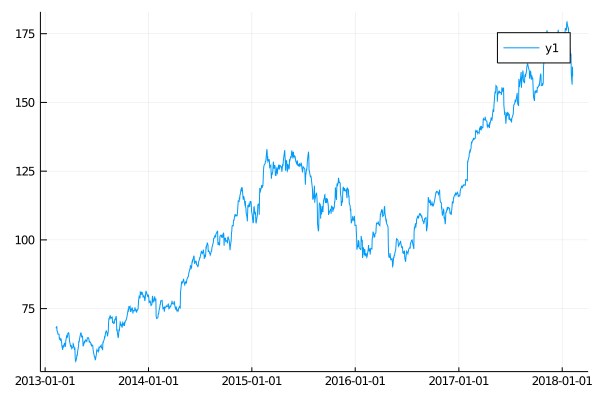

In [2]:
aapl_data = CSV.File("./example2_stocks/AAPL_data.csv") # load the data into a data frame "aapl_data"
plot(aapl_data.date,aapl_data.close)

We can also calculate the return by computing ratio between closing and opening prices:

$$ R_i(t) =  \frac{ \text{closing price} - \text{opening price} }{ \text{opening price} } = \frac{ s_i^{close}(t) -s_i^{open}(t) }{ s_i^{open} (t) } $$

In Julia, this can be computed conveniently using the "./" for element wise division. (Recall that "aapl_data.close" and "aapl_data.open" are vectors of dimension $T \times 1$)

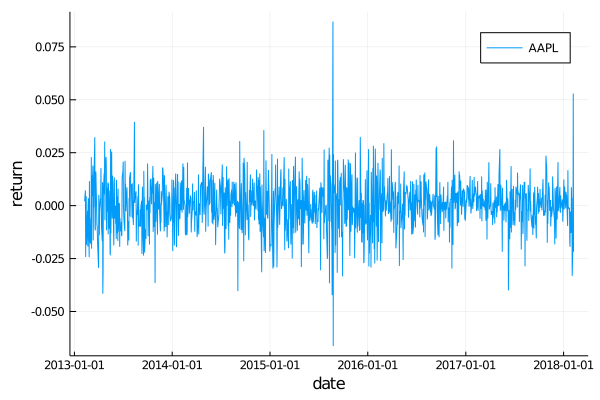

In [3]:
aapl_return = (aapl_data.close - aapl_data.open)./aapl_data.open
plot(aapl_data.date, aapl_return, label="AAPL", ylabel="return", xlabel="date")

In [4]:
print("average return: ", mean(aapl_return))

average return: 0.000138513700194019

## 2. Index Fund Problem

We formulate the index fund problem by first collecting the "similarity" data between the stocks. Precisely, we consider a simple index fund problem for selecting $q=3$ stocks from $n=9$ stocks. The 9 stocks under consideration are:

Apple ("AAPL"), Alphabet ("GOOGL"), Microsoft ("MSFT"), 

Wells Fargo ("WFC"), Bank of America ("BAC"), JP Morgan ("JPM"), 

Crown Castle ("CCI"), Simon Property Group ("SPG"), American Tower ("AMT")

Note that the first 3 are tech companies, the 4th-6th are banks, and the last 3 are real estate companies. 

In [5]:
# The following code loads *all* the files under "./example2_stock/" with the suffix "_data.csv"
files = glob( "*_data.csv", "./example2_stocks/" );
dfs = DataFrame.( CSV.File.( files ) );
# We can load the data 
T = 1259; n = length(dfs);
stocks_retur = zeros(T,n);
for i = 1:n
    # compute the realized return R_i(t)
    stocks_retur[:,i] = (dfs[i].close-dfs[i].open) ./ dfs[i].open;
end
names_stocks = [ dfs[i].Name[1] for i in 1:n ];

In the above "stock_retur" is a matrix of dimension $T \times 9$ where each column is the past return for a stock, e.g.,

$$ \texttt{stock_retur} = \left( \begin{array}{cccc} 
R_1(1) & R_2(1) & \cdots & R_9(1) \\
R_1(2) & R_2(2) & \cdots & R_9(2) \\
& & \vdots & \\
R_1(T) & R_2(T) & \cdots & R_9(T) 
\end{array} \right) $$

Let us calculate the similarity between stocks as the correlation between their respective return after removing the global average return $\overline{R}$, i.e.,

$$ \rho_{ij} = \frac{1}{T \sqrt{\sum_{t=1}^T ( R_i(t) - \overline{R} )^2 \sum_{t'=1}^T ( R_j(t') - \overline{R} )^2 }} \sum_{t=1}^T ( R_i(t) - \overline{R} )( R_j(t) - \overline{R} )  $$

The following codes compute the global return and the squared sums in the denominator. 

In [6]:
overline_R = mean( stocks_retur[:] ); var_R = zeros(n,1)
for i = 1:n
    var_R[i] = sum( ( stocks_retur[:,i] .- overline_R ).^2 ) / T
end
print("global return is ", overline_R)

global return is 0.0001837658902535992

It can be checked that each term in the nominator can be computed by a matrix product:

$$ \big( \texttt{stock_retur} - \overline{R} \big)^\top \big( \texttt{stock_retur} - \overline{R} \big) $$

which gives a square matrix of size $9 \times 9$.

In [7]:
similarity_matrix = (1/T) .* 
    (stocks_retur .- overline_R)' * (stocks_retur .- overline_R) ./ (sqrt.(var_R*var_R')) 

9×9 Array{Float64,2}:
 1.0       0.198586  0.329848  0.136976  …  0.400602  0.156756  0.298791
 0.198586  1.0       0.165628  0.615831     0.293763  0.388767  0.211008
 0.329848  0.165628  1.0       0.113187     0.337532  0.156735  0.68805 
 0.136976  0.615831  0.113187  1.0          0.242488  0.329737  0.177199
 0.424452  0.300117  0.350737  0.225524     0.502468  0.205122  0.320555
 0.344234  0.201025  0.78019   0.176806  …  0.399527  0.209615  0.709738
 0.400602  0.293763  0.337532  0.242488     1.0       0.226565  0.348456
 0.156756  0.388767  0.156735  0.329737     0.226565  1.0       0.249523
 0.298791  0.211008  0.68805   0.177199     0.348456  0.249523  1.0     

The heatmap illustrates how the similarity matrix looks like, where lighter color denotes higher similarity.

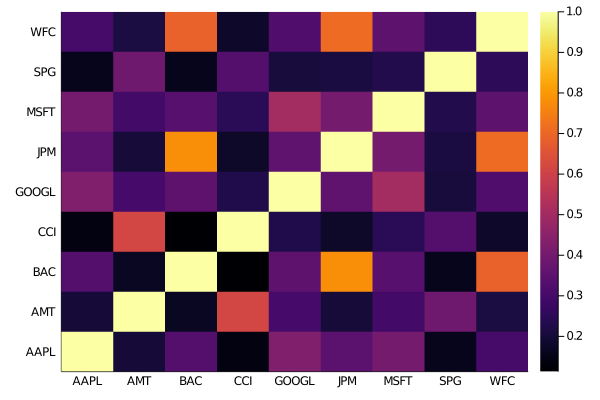

In [8]:
heatmap( names_stocks, names_stocks, similarity_matrix)

# 3. Calling JuMP to formulate and solve the index fund problem

We will use JuMP to solve the following index fund problem:

$$\begin{array}{rl}
\max_{ X, y } & \sum_{i=1}^n \Big( \sum_{j=1}^n x_{ij} \rho_{ij} \Big)  \\
{\rm s.t.} & \sum_{j=1}^n y_j = q \\
& \sum_{j=1}^n x_{ij} = 1 \\
& x_{ij} \leq y_j,~i=1,...,n \\
& y_j \in \{0,1\},~x_{ij} \in \{0,1\},~i,j=1,...,n.
\end{array}$$

such that $X_{ij} = 1$ if stock $j$ is the most similar to stock $i$, and $y_i = 1$ if stock $i$ is selected in the $q$ choices.

To begin with, let us construct the optimization model in JuMP as usual. Since the problem is an integer program, we shall use the solver "GLPK.Optimizer" as follows

In [9]:
q = 3; 
model = Model(GLPK.Optimizer);

We define the decision variables $X$ and $y$ as $n \times n$ binary matrix and $n \times 1$ binary vector, respectively.

In [10]:
@variable(model, X[1:n,1:n], Bin);
@variable(model, y[1:n], Bin);

We specify the constraints as follows:

In [11]:
@constraint(model, sum(y) == q);
@constraint(model, [i=1:n], sum(X[i,:]) == 1); # the second argument specifies the constraints for all i=1,..,n
@constraint(model, [i=1:n,j=1:n], X[i,j] <= y[j]);

Note that the 2nd and 3rd constraints are specified in a for-loop like manner. In particular, 

"@constraint(model, [i=1:n], sum(X[i,:]) == 1)" means that the constraint "sum(X[i,:]) == 1" is repeated for $i=1,...,n$.

Finally, we set the objective function which is simply the inner product between $X$ and $\rho$:

In [12]:
@objective(model, Max, sum(similarity_matrix.*X) );

In [13]:
status = optimize!(model)

Let's find out what are the selected stocks in the constructed fund.

In [14]:
names_stocks[ findall( x->x==1, Int.(value.(y)) ) ]

3-element Array{String,1}:
 "AMT"  
 "GOOGL"
 "JPM"  

The selected stocks make sense since one comes from the tech sector, one from the bank sector and one from the real estate sector. The next few code sniplets show a few more details about the optimal solution found.

In [15]:
objective_value(model)

6.421445484804637

In [16]:
value.(X)

9×9 Array{Float64,2}:
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0

## In/after-class Exercise

Now, can you construct an index fund with $q=5$ from the following $n=18$ stocks?

AT&T ("T"), Century Link ("CTL"), Comcast ("CMCSA"), Verizon ("VZ"), Dish Networks ("DISH"), McDonalds ("MCD"), Chipotle ("CMG"), Starbucks ("SBUX"), Intel ("INTC"), Nvidia ("NVDA"), Qualcomm ("QCOM"), AMD ("AMD"), Adobe ("ADBE"), Symantec ("SYMC"), Oracle ("ORCL"), Synopsys ("SNPS"), General Motors ("GM"), Ford Motors ("F")

The data for these stocks can be found in the folder "example2_additional_stocks".

Furthermore, modify the index fund problem such that each stock can be matched to a maximum of 2 stocks in the fund.  